In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor,RandomForestClassifier
from xgboost import XGBRegressor
from sklearn import ensemble
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
Top200 = pd.read_csv('Top200_Stations.csv',index_col=0)

C:\Users\zhang\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
Top200.head()

,start_station_latitude,start_station_longitude,start_hour,start_year,start_month,start_day,start_dayofweek,start_station_checkout_counts,start_station_checkin_counts,AWND,...,Haze,TAVG,HasPRCP,HasSNOW,tot_docks,Percent_usage,Isweekday,holidays,Commute,cluster
0,40.751873,-73.977706,18,2017,1,19,4,92.0,72.0,3.58,...,0.0,44.0,0,0,61.0,2.688525,1,0,1,1.0
2,40.722174,-73.983688,8,2017,1,4,3,17.0,3.0,8.05,...,1.0,43.0,0,0,37.0,0.540541,1,0,1,2.0
3,40.732233,-73.988900,20,2017,1,13,5,6.0,4.0,7.16,...,0.0,47.0,0,0,35.0,0.285714,1,0,0,2.0
4,40.755942,-74.002116,18,2017,1,25,3,8.0,3.0,6.71,...,0.0,43.5,0,0,39.0,0.282051,1,0,1,2.0
5,40.730473,-73.986724,6,2017,1,25,3,5.0,1.0,6.71,...,0.0,43.5,0,0,39.0,0.153846,1,0,0,2.0


## Lasso Model 

In [4]:
# X = Top200.drop('start_station_checkout_counts',axis = 1)
# Y = Top200.start_station_checkout_counts

In [5]:
# X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=42)

In [6]:
# lasso = Lasso(normalize=True,tol=0.01)
# alphas = np.logspace(-8,-2,100)

# alpha_coefs = []
# for alpha in alphas:
#     lasso.set_params(alpha=alpha)
#     lasso.fit(X, Y)
#     alpha_coefs.append(lasso.coef_)
    
# # the order of predictors to become zero coefficient
# coefs_df = pd.DataFrame(alpha_coefs, index=alphas, columns = list(X.columns))

In [7]:
# plt.figure(figsize=(20,10))
# for name in coefs_df.columns:
#     plt.plot(coefs_df.index, coefs_df[name], label=name)
# plt.xlabel(r'hyperparameter $\lambda$')
# plt.ylabel(r'slope values')
# plt.legend(loc=1)   

In [8]:
# ### find the alpha where coefficient becomes zero ###
# alpha_zero = {}
# for col in coefs_df.columns:
#     for alpha in coefs_df.index:
#         if coefs_df.loc[alpha, col] == 0:
#             alpha_zero[col] = alpha
#             break
# alpha_zero = sorted(alpha_zero.items(), key=lambda x: x[1], reverse=True)
# alpha_zero

## Tree Based Models

In [9]:
X = Top200.drop(['start_station_checkout_counts','Percent_usage','start_station_checkin_counts'],axis = 1)
Y = Top200.start_station_checkout_counts

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=42)

### XGBoost

In [11]:
xgb = XGBRegressor()
xgb.set_params(subsample=0.7,random_state=42, n_estimators=1200,eta=0.04)
%time xgb.fit(X_train,y_train)

Wall time: 14min 10s


XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.04, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints=None,
             learning_rate=0.0399999991, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=1200, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.7, tree_method=None,
             validate_parameters=False, verbosity=None)

In [12]:
print('Training score is %.3f' %(xgb.score(X_train,y_train)))
print('Testing score is %.3f' %(xgb.score(X_test,y_test)))

Training score is 0.722
Testing score is 0.710


In [13]:
sorted_importance_xgb = sorted(zip(X_train.columns.values, xgb.feature_importances_), key=lambda t:t[1], reverse=True)
sorted_importance_xgb

[('cluster', 0.24626362),
 ('Commute', 0.20675604),
 ('TAVG', 0.08225282),
 ('tot_docks', 0.06661223),
 ('TMAX', 0.061792966),
 ('start_hour', 0.05599702),
 ('start_station_latitude', 0.040986177),
 ('start_station_longitude', 0.03996174),
 ('start_dayofweek', 0.036518183),
 ('PRCP', 0.024405405),
 ('start_month', 0.022487637),
 ('start_year', 0.020158527),
 ('TMIN', 0.018164307),
 ('holidays', 0.016021231),
 ('Heavy_Fog', 0.012401098),
 ('Fog', 0.00859361),
 ('start_day', 0.008453688),
 ('Haze', 0.007257712),
 ('SNWD', 0.006696183),
 ('AWND', 0.006387577),
 ('Thunder', 0.005518719),
 ('SNOW', 0.004375421),
 ('Glaze', 0.0019380499),
 ('Hail', 0.0),
 ('HasPRCP', 0.0),
 ('HasSNOW', 0.0),
 ('Isweekday', 0.0)]

Text(0.5, 1.0, 'Feature Importance Plot for XgBoost Model')

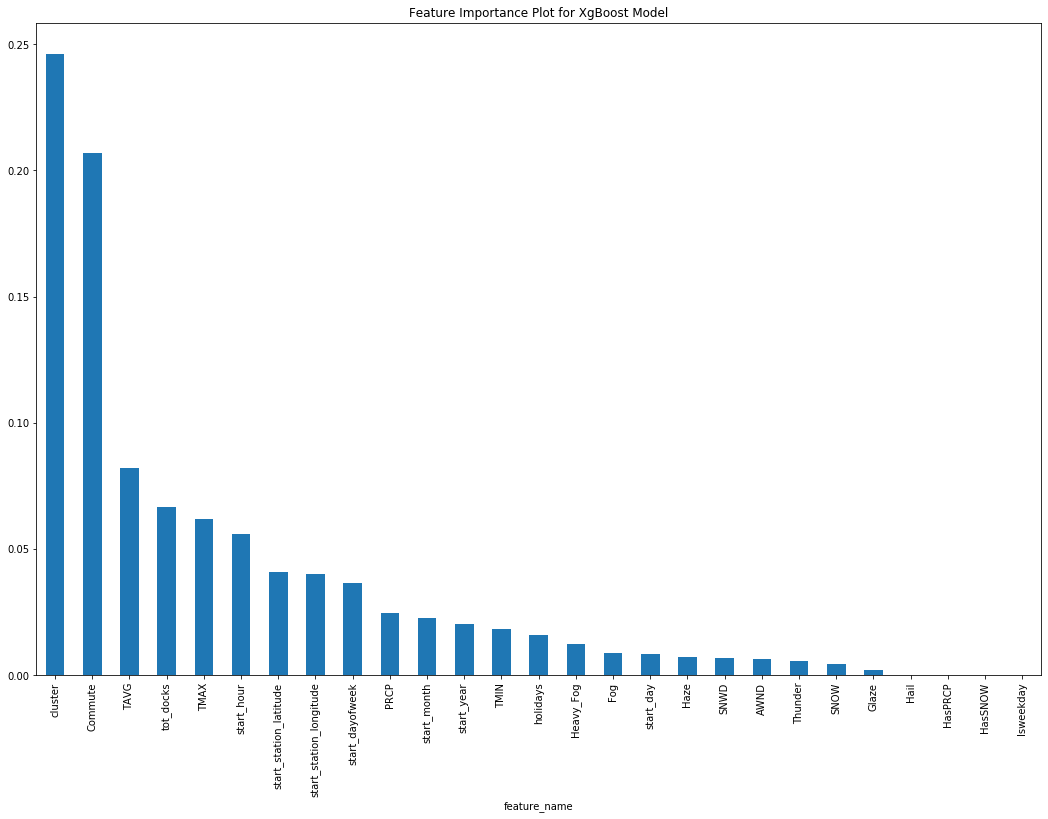

In [14]:
plt.rcParams['figure.figsize'] = (18,12)
a, b = zip(*sorted_importance_xgb) # this splits the list of tuples into two lists
pd.DataFrame({'feature_name':a, 'importance_score':b}).plot.bar(x='feature_name',y='importance_score', legend=None)
plt.title('Feature Importance Plot for XgBoost Model')

In [ ]:
grid_params = {'max_depth': range(4,8,3),
               'eta':np.linspace(0.02,0.1,5),
              'n_estimator':np.linspace(1000,1400,5)}
grid_search_xgb = GridSearchCV(xgb, grid_params, cv = 5)
%time grid_search_xgb.fit(X_train,y_train)

In [ ]:
grid_search_xgb.best_params_

In [ ]:
grid_search_xgb.score(X_train,y_train)

In [ ]:
grid_search_xgb.score(X_test,y_test)

### Gradient Boosting

In [ ]:
gbm = GradientBoostingRegressor()
gbm.set_params(learning_rate=0.03, n_estimators=900, subsample=0.7, loss='ls', max_depth=4, max_features=2,\
               min_impurity_decrease=0.01,random_state = 42)
%time gbm.fit(X_train,y_train)

In [ ]:
print('Training score is %.3f' %gbm.score(X_train,y_train))
print('Testing score is %.3f' %gbm.score(X_test,y_test))

In [ ]:
sorted_importance_gbm = sorted(zip(X_train.columns.values, gbm.feature_importances_), key=lambda t:t[1], reverse=True)
sorted_importance_gbm

In [ ]:
plt.rcParams['figure.figsize'] = (18,12)
a, b = zip(*sorted_importance_gbm) # this splits the list of tuples into two lists
pd.DataFrame({'feature_name':a, 'importance_score':b}).plot.bar(x='feature_name',y='importance_score', legend=None)
plt.title('Feature Importance Plot for GBM model')

In [ ]:
grid_params = {'max_depth': range(4,8,3),
               'learning_rate':np.linspace(0.01,0.1,10),
              "min_samples_split": np.linspace(start=5, stop=20, num=5, dtype=int)}
grid_search_gbm = GridSearchCV(gbm, grid_params, cv = 5)
%time grid_search_gbm.fit(X_train,y_train)

In [ ]:
grid_search_gbm.best_param_

## Classification on Turnover Rate

### Random Forest

In [ ]:
Top200['High_turnover']=[1 if x>0.49 else 0 for x in Top200['Percent_usage']]

In [ ]:
columns_to_drop = ['High_turnover', 'Percent_usage', 'start_station_checkout_counts', 'start_station_checkin_counts']
X_class = Top200.drop(columns_to_drop,axis = 1)
Y_class = Top200.High_turnover

In [ ]:
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, Y_class, train_size=0.8, test_size=0.2, random_state=42)

In [ ]:
randomForest = RandomForestClassifier()

In [ ]:
randomForest.set_params(random_state=42, max_features=4)
%time randomForest.fit(X_train_class, y_train_class)  

In [ ]:
print('RandomForest train test score is %.3f' %(randomForest.score(X_train_class, y_train_class)))
print('RandomForest test test score is %.3f' %(randomForest.score(X_test_class, y_test_class)))

In [ ]:
feature_importance = list(zip(X_train_class.columns, randomForest.feature_importances_))
feature_importance

In [ ]:
dtype = [('feature', 'S10'), ('importance', 'float')]
feature_importance = np.array(feature_importance, dtype=dtype)
feature_sort = np.sort(feature_importance, order='importance')[::-1]
name, score = zip(*list(feature_sort))
pd.DataFrame({'name':name,'score':score})[:15].plot.bar(x='name', y='score')

In [ ]:
grid_params = {'max_features':np,linspace(2,6,3),
               'n_estimators':np.linspace(100,500,5)}
grid_search_randomForest = GridSearchCV(randomForest, grid_params, cv = 5)
%time grid_search_randomForest.fit(X_train_class,y_train_class)